In [1]:
# Phase-1: A simple OOP based program for simple beam solving:
import math
import os
import __main__
from inspect import Attribute
from logging import raiseExceptions
from typing import Iterable
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp

"""
# About Beam library:
A beam is a structural element that primarily resists loads applied laterally to the beam's axis.
Its mode of deflection is primarily by bending.

This library has several class and their methods in order to solve a 2d Beam numerically and do beam analysis.

## Sign Conventions:
Positive x-axis for beam: increases in right hand side
Positive y-axis for beam: increases upward direction
Positive angle direction: Counter clockwise with respect to beam positive x-axis
Positive moment: Counter clockwise

## Units Conventions:
Length: meter
Angle: degrees
Load: kN
Moment: kNm
"""


class Beam:
    """
        `Beam` is the main class to represent a beam object and perform various calculations.

        ## Attributes
        `length(float)`: length of a beam

        `kwargs`: Here are few optional keyword arguments
        - `E(float)` = Modulus of Elasticity of beam material 
        - `I(float)` = 2nd moment of area of the cross section of beam
    
        #### Example
        ```
        # to create a beam of length 5m:
        b = Beam(5)
        ```
    """
    # initial kwargs lists for simply supported beam
    simply_supported = ('Elasticity', 'MOA')
    # fonts specification for graphs
    plt.rc('font', family='serif', size=14)

    def __init__(self, length: float, **kwargs):
        self.length = length
        # modulus of elasticity of the material
        self.E = kwargs.get('E') or kwargs.get('Elasticity')
        self.I = kwargs.get('I') or kwargs.get('MOA')  # second moment of area

        self.supports = kwargs.get('supports')
        # self.reactions
        # variables initialization for beam:
        self.x, self.V_x, self.M_x = sp.symbols('x V_x M_x')

        # intitial fx,fy,moment
        self.fx = 0  # sp.symbols('fx') #total sum of horizontal force
        self.fy = 0  # sp.symbols('fy') #total sum of vertical force
        # sp.symbols('m') #total sum of moments about any point on beam
        self.m = 0
        # total sum of moments about hinge (of one side of beam only)
        self.m_hinge = 0

        self.solved_rxns = None  # initialize variable to store solved values for reactions
        self.mom_fn = 0  # initialize variable to store bending moment values in numpy array
        self.shear_fn = 0  # initialize variable to store shear values in numpy array

    def add_loads(self, load_list: object):
        """
        ### Description:
        Adds different load values and Reaction variables to generate symbolic expression of all loads
        This will add respective component of different netload values. 
        `self.fx: x-components` and 
        `self.fy: y-components`

        #### Arguments
        `load_list` = List or Tuples of various load objects like `PointLoad, UDL, Reaction`

        """
        for loadtype in load_list:
            if isinstance(loadtype, PointLoad):
                self.fx += loadtype.load_x
                self.fy += loadtype.load_y

            elif isinstance(loadtype, Reaction):
                if hasattr(loadtype, 'rx_var'):
                    self.fx += loadtype.rx_var
                    self.fy += loadtype.ry_var
                else:
                    self.fy += loadtype.ry_var

            elif isinstance(loadtype, UDL):
                self.fy += loadtype.netload  # adds net load value of udl object

            elif isinstance(loadtype, UVL):
                self.fy += loadtype.netload

    def add_moments(self, momgen_list: object, about: float = 0):
        """
        ### Description
        Receives a list or tuple of `PointLoad`, `Reaction`, `UDL` or `PointMoment` objects.
        Adds the moment due to those objects about origin.

        #### Sign Convention: 
        Anticlockwise moment are positively added. So, positive forces will give anticlockwise moments.

        #### Arguments and terms:
        - `momgen_list` = List or Tuples of various moment generators like `PointLoad, UDL, Reaction, PointMoment`
        - `about = 0`= Take moment about that x-coordinate in beam. `Default = 0, range = (0, self.length)`
        - `mom_gen(local variable)` = One which is capable of generating moment.
        """
        for mom_gen in momgen_list:  # takes moment about origin and adds up
            if isinstance(mom_gen, PointLoad):
                self.m += (mom_gen.pos-about)*mom_gen.load_y
            elif isinstance(mom_gen, UDL):
                self.m += (mom_gen.pos-about)*mom_gen.netload
            elif isinstance(mom_gen, UVL):
                self.m += (mom_gen.pos-about)*mom_gen.netload
            elif isinstance(mom_gen, Reaction):
                self.m += (mom_gen.pos-about)*mom_gen.ry_var
                if hasattr(mom_gen, 'mom_var'):
                    self.m += mom_gen.mom_var
            elif isinstance(mom_gen, PointMoment):
                self.m += mom_gen.mom

            # for internal hinge
            elif isinstance(mom_gen, Hinge):
                # dictionary of load separated to left and right of hinge
                separate_load = {
                    'l': [mgen for mgen in momgen_list if mgen.pos < mom_gen.pos],
                    # 'l' = moment generators to left of hinge
                    'r': [mgen for mgen in momgen_list if mgen.pos > mom_gen.pos]
                    # 'r' =  moment generators to right of hinge
                }
                                
                # now take loads according to side specified in hinge class
                for side_mom_gen in separate_load[mom_gen.side[0]]:
                    if isinstance(side_mom_gen, PointLoad):
                        self.m_hinge += (side_mom_gen.pos -
                                         mom_gen.pos)*side_mom_gen.load_y
                    elif isinstance(side_mom_gen, Reaction):
                        self.m_hinge += (side_mom_gen.pos -
                                         mom_gen.pos)*side_mom_gen.ry_var
                        if hasattr(side_mom_gen, 'mom_var'):
                            self.m_hinge += side_mom_gen.mom_var
                    elif isinstance(side_mom_gen, PointMoment):
                        self.m_hinge += side_mom_gen.mom
                    elif isinstance(side_mom_gen, UDL):
                        if side_mom_gen.end > mom_gen.pos & side_mom_gen.start<mom_gen.pos:
                            # cut and take left portion of udl
                            if mom_gen.side[0]=='l':
                                cut_udl = UDL(side_mom_gen.start, side_mom_gen.loadpm, mom_gen.pos-side_mom_gen.end)
                            else:
                                cut_udl = UDL(mom_gen.pos, side_mom_gen.loadpm, side_mom_gen.end-mom_gen.pos)

                            self.m_hinge += cut_udl.netload * \
                                (cut_udl.pos-mom_gen.pos)
                        else:
                            self.m_hinge += side_mom_gen.netload * \
                                (side_mom_gen.pos-mom_gen.pos)
                    # elif isinstance(left_mom_gen, UVL):
                    #self.m_hinge += (left_mom_gen.netpos-about)*left_mom_gen.netload
                    elif isinstance(side_mom_gen, Reaction):
                        self.m_hinge += (side_mom_gen.pos -
                                         about)*side_mom_gen.ry_var
                        if hasattr(side_mom_gen, 'mom_var'):
                            self.m_hinge += side_mom_gen.mom_var

    def calculate_reactions(self, reaction_list: object):
        """
        ### Description
        1. Generates 3 equations of static equilibrium: `self.fx=0 , self.fy=0,  self.m=0`.
        2. Uses `sympy.solve` to solve for symbolic variables `'rx_var', 'ry_var', 'mom_var'` in those equations. 
        3. Assign those values for unknown value of reactions object: `rx_val, ry_val, mom_val`.

        #### Arguments
        List or tuple of unknown reaction objects
        """
        Fx_eq = sp.Eq(self.fx, 0)
        Fy_eq = sp.Eq(self.fy, 0)
        M_eq = sp.Eq(self.m, 0)
        M_hinge = sp.Eq(self.m_hinge, 0)

        eval_values = []  # initialize an empty list to contain reactions variables to be solved
        possible_rxn = ['rx_var', 'ry_var', 'mom_var']
        possible_values = ['rx_val', 'ry_val', 'mom_val']
        for rxn_obj in reaction_list:
            for rxn_var in possible_rxn:
                if hasattr(rxn_obj, rxn_var):
                    eval_values.append(getattr(rxn_obj, rxn_var))
        print(eval_values)
        print([Fx_eq, Fy_eq, M_eq, M_hinge])
        self.solved_rxns = sp.solve([Fx_eq, Fy_eq, M_eq, M_hinge], eval_values)
        print(self.solved_rxns)
        # now assign values to the reaction objects too:
        for rxn_obj in reaction_list:
            for (rxn_val, rxn_var) in zip(possible_values, possible_rxn):
                if hasattr(rxn_obj, rxn_var):
                    setattr(rxn_obj, rxn_val,
                            self.solved_rxns[getattr(rxn_obj, rxn_var)])

    def generate_moment_equation(self, loads: object):
        """
        ### Description
        1. Generates Macaulay's Equation for Moment due to various moment generators
        2. Assigns symbolic expression of BM to `self.mom_fn` attribute 
        3. Reassigns lambdified expression of BM to `self.mom_fn`
        4. Reassigns `numpy.vectorize()` expression to `self.mom_fn`

        #### Arguments
        List or Tuple of various moment generating objects:`PointLoad`, `Reaction`, `UDL` or `PointMoment`
        """
        for mom_gen in loads:
            if isinstance(mom_gen, PointLoad):
                self.mom_fn += mom_gen.load_y * \
                    sp.SingularityFunction('x', mom_gen.pos, 1)
            elif isinstance(mom_gen, Reaction):
                self.mom_fn += mom_gen.ry_val * \
                    sp.SingularityFunction('x', mom_gen.pos, 1)
                if hasattr(mom_gen, 'mom_val'):
                    self.mom_fn -= mom_gen.mom_val * \
                        sp.SingularityFunction('x', mom_gen.pos, 0)
            elif isinstance(mom_gen, PointMoment):
                self.mom_fn -= mom_gen.mom * \
                    sp.SingularityFunction('x', mom_gen.pos, 0)
                # because we have defined anticlockwise moment positive in PointMoment
            elif isinstance(mom_gen, UDL):
                self.mom_fn += mom_gen.loadpm * \
                    sp.SingularityFunction('x', mom_gen.start, 2)/2
                if mom_gen.end < self.length:
                    self.mom_fn -= mom_gen.loadpm * \
                        sp.SingularityFunction('x', mom_gen.end, 2)/2

        # in order to lambdify moment_equation and vectorize it:
        self.mom_fn = sp.lambdify(self.x, self.mom_fn, 'sympy')
        self.mom_fn = np.vectorize(self.mom_fn)

    def generate_shear_equation(self, loads):
        """
        ### Description
        1. Generates Macaulay's Equation for Shear Force due to various force generators
        2. Assigns symbolic expression of ShearForce to `self.shear_fn` attribute 
        3. Reassigns lambdified expression of ShearForce to `self.shear_fn`
        4. Reassigns `numpy.vectorize()` expression to `self.shear_fn`

        #### Arguments
        List or Tuple of various force generating objects:`PointLoad`, `Reaction`, `UDL` 
        """
        for force_gen in loads:
            if isinstance(force_gen, PointLoad):
                self.shear_fn += force_gen.load_y * \
                    sp.SingularityFunction('x', force_gen.pos, 0)
            elif isinstance(force_gen, Reaction):
                self.shear_fn += force_gen.ry_val * \
                    sp.SingularityFunction('x', force_gen.pos, 0)
            elif isinstance(force_gen, UDL):
                self.shear_fn += force_gen.loadpm * \
                    sp.SingularityFunction('x', force_gen.start, 1)
                if force_gen.end < self.length:  # add udl in opposite direction
                    self.shear_fn -= force_gen.loadpm * \
                        sp.SingularityFunction('x', force_gen.end, 1)

            elif isinstance(force_gen, UVL):
                if abs(force_gen.startload) < abs(force_gen.endload):
                    if force_gen.inverted:
                        self.shear_fn += ( force_gen.startload * sp.SingularityFunction('x', force_gen.start, 1) - force_gen.gradient*sp.SingularityFunction('x', force_gen.start, 2)/2 )
                    elif not force_gen.inverted:
                        self.shear_fn += ( force_gen.startload * sp.SingularityFunction('x', force_gen.start, 1) + force_gen.gradient*sp.SingularityFunction('x', force_gen.start, 2)/2 )
                    if force_gen.end < self.length: #add uvl in opposite direction
                        if force_gen.inverted:
                            self.shear_fn -= ( force_gen.endload * sp.SingularityFunction('x', force_gen.end, 1) - force_gen.gradient*sp.SingularityFunction('x', force_gen.end, 2)/2 )
                        if not force_gen.inverted:
                            self.shear_fn -= ( force_gen.endload * sp.SingularityFunction('x', force_gen.end, 1) + force_gen.gradient*sp.SingularityFunction('x', force_gen.end, 2)/2 )
                
                elif abs(force_gen.startload) > abs(force_gen.endload):
                    if force_gen.inverted:
                        self.shear_fn += ( force_gen.startload * sp.SingularityFunction('x', force_gen.start, 1) - force_gen.gradient*sp.SingularityFunction('x', force_gen.start, 2)/2 )
                    if not force_gen.inverted:
                        self.shear_fn += ( force_gen.startload * sp.SingularityFunction('x', force_gen.start, 1) + force_gen.gradient*sp.SingularityFunction('x', force_gen.start, 2)/2 )

                    if force_gen.end < self.length: #add uvl in opposite direction
                        if force_gen.inverted:
                            self.shear_fn -= ( force_gen.endload * sp.SingularityFunction('x', force_gen.end, 1) - force_gen.gradient*sp.SingularityFunction('x', force_gen.end, 2)/2 )
                        if not force_gen.inverted:
                            self.shear_fn -= ( force_gen.startload * sp.SingularityFunction('x', force_gen.end, 1) + force_gen.gradient*sp.SingularityFunction('x', force_gen.end, 2)/2 )                 
                
        print(self.shear_fn)
        self.shear_fn = sp.lambdify(self.x, self.shear_fn, 'sympy')
        self.shear_fn = np.vectorize(self.shear_fn)

    def generate_graph(self, **kwargs):
        """
        To generate bending moment diagram for beam with all reactions solved

        ### Optional Arguments:
        - `save_fig:bool` = To specify whether or not to save the generated image locally
        - `save_path:str` = Relative or absolute of path to save the generate image
            - `save_fig` and `save_path` must be used together
        """
        save_path = kwargs.get('save_path')
        if save_path == None:
            os.mkdir("images")
            save_path = f"images/{__main__.__file__.split('/')[-1][:-3]}.png"
        
        
        x = np.linspace(-1, self.length, 500)
        fig, ax = plt.subplots(facecolor='w', edgecolor='w', num="Bending Moment Diagram")
        ax.plot(x, self.mom_fn(x), label="BMD")
        ax.set_xticks(range(0, self.length+1,1))
        ax.axhline(y=0, color='k', label='Beam')
        ax.set_title("Bending Moment Diagram")
        ax.set_xlabel("x (m)")
        ax.set_ylabel("BM (kNm)")
        ax.legend(fontsize=8)
        ax.grid()
        if kwargs.get('savefig') == True:
            fig.savefig(fname = save_path)
        plt.show()

class Load:
    '''
    Load class 

    ### Attributes:
    `pos(float)`: `unit:meter` position of that netload with respect to beam coordinates's origin
    `load(float)`: `unit:kN` net load of that load type(for point load that is point load value, 
                            but it will be different 
                            for other loads like uvl and udl)
    `inverted(bool)=False`: Default direction of positive net load is in positive direction of y-axes
    - by default: `inverted = False` (load is facing upward)
    - use `inverted=True` to indicate load is in downward direction

    '''

    def __init__(self, pos: float, load: float, inverted=False, **kwargs):
        self.pos = pos
        self.inverted = inverted
        if self.inverted:
            self.load = -1*load
        else:
            self.load = load


class PointLoad(Load):
    """
    ## Description 
    Subclass of Class Load

    ### Attributes:
    `pos, load, inverted`: inherit from super class `Load`
    `inclination(float)=90`: `unit=degree` represents angle made by direction of net load with positive direction of beam's x axis
                            inclination will be positive for counter clockwise direction
                            put negative inclination if you want to take angle in clockwise direction
    `load_x`: component of net load value in positive direciton of beam's x-axis
    `load_y`: component of net load value in positive y-direciton(upward direction)
    """

    def __init__(self, pos: float, load: float, inverted: bool = False, inclination=90, **kwargs):
        super().__init__(pos, load, inverted, **kwargs)
        # self.var = sp.symbols(var) #might require variable for load too.
        # inclination of point load with positive direction of beam axis
        self.inclination = inclination
        self.load_x = round(
            self.load*np.cos(self.inclination*np.pi/180), ndigits=4)
        self.load_y = round(
            self.load*np.sin(self.inclination*np.pi/180), ndigits=4)


class UDL:
    """
    ## Description
    UDL is type of load that is combinaiton of infinite points load over certain length acting transverse to beam

    ### Attributes:
    `start(float)`:Start position of UDL
    `loadpm(float)`: Load Per meter of udl
    `span(float)`: Total length of udl
    `inverted(bool) = True`: UDL facing downwards on beam,
                                use `inverted=False` for upside udl
    `self.netload(float)`: total effective load of udl
    `self.pos(float)`: position of effective load from beam origin
    """

    def __init__(self, start: float, loadpm: float, span: float, inverted: bool = True, **kwargs):
        self.start = start  # x coordinate of left edge of udl
        self.span = span  # total length of udl
        self.end = start + span
        self.inverted = inverted
        if self.inverted:
            self.loadpm = -1*loadpm
        else:
            self.loadpm = loadpm

        self.netload = self.loadpm * self.span  # netload of udl
        self.pos = self.start + self.span/2  # position of effective load of udl


class UVL:
    """
    ## Description
    It is that load whose magnitude varies along the loading length with a constant rate. 
    Uniformly varying load is further divided into two types;
        1. Triangular Load
        2. Trapezoidal Load

    ### Arguments
    1. `start:float` = Start position of uvl from beam's origin along x-axis of beam coordinate system
    2. `startload:float` = `unit: kN/m` = Starting load/m value of uvl
    3. `span:float` = Total length of uvl object
    4. `endload:float` = Ending load/m value of uvl object
    5. `inverted:bool= True` : Default=`True` Inverts the uvl object

    ### Attributes
    - `self.end` = End coordinate of uvl object
    - `self.tload` = Net load value of upper triangular part of trapezoidal or triangular load
    - `self.rload` = Net load value of lower rectangular part of trapezoidal load itself
    - `self.netload` = Net load of whole uvl object itself. `netload = tload + rload`
    - `self.netpos` = Net position(coordinates) where net load of uvl acts
    """

    def __init__(self, start: float, startload: float, span: float, endload: float, inverted: bool = True, **kwargs):
        self.start = start
        self.span = span
        self.end = span+start
        self.inverted = inverted

        if self.inverted:
            self.startload = -1*startload
            self.endload = -1*endload
        else:
            self.startload = startload
            self.endload = endload

        #gradient of uvl:
        self.gradient = (endload-startload)/span
        if startload>endload:
            self.zero_load = startload / abs(self.gradient)

        # for upper triangular part: 1/2*b*h
        self.tload = self.span*abs(self.endload-self.startload)/2
        # for lowe rectangular part: b*h
        self.rload = self.span*min(abs(self.startload), abs(self.endload))

        self.netload = self.span*(self.startload + self.endload)/2  # net load

        if abs(self.endload) > abs(self.startload):
            self.pos = self.start + \
                (2*self.tload*self.span/3 + self.rload*self.span/2)/abs(self.netload)
        else:
            self.pos = self.start + \
                (self.tload*self.span/3 + self.rload*self.span/2)/abs(self.netload)


class Reaction:
    """
    ## Description
        Reactions are given by supports. 3 types of supports are defined for now
        `hinge`, `roller` and `fixed` support.

   ### Arguments
    - `pos(float)`: position of reaction
    - `type(str)`: any one of `('roller'`,`'hinge'`,`'fixed')` or `('r'`,`'h'`,`'f')` Representing support condition at that point.
    - `pos_sym(str)`: Symbolic variable to represent support location name 

    ### Attributes
    - `rx_val, ry_val, mom_val`: variables to store numerical values for reaction loads and moments
    - `rx_var, ry_var, mom_var`: symbolic variables to store symbolic values for reactions
"""

    def __init__(self, pos: float, type: str, pos_sym: str):
        self.pos = pos
        # possible reaction values(initialize them as zeros):
        self.rx_val = 0
        self.ry_val = 0
        self.mom_val = 0

        self.type = type.lower()
        if self.type == 'roller' or self.type == 'r':
            # symbolic variable for that roller support
            self.ry_var = sp.Symbol(f"R_{pos_sym}_y")
        elif self.type == 'hinge' or self.type == 'h':
            self.rx_var = sp.Symbol(f"R_{pos_sym}_x")
            self.ry_var = sp.Symbol(f"R_{pos_sym}_y")
        elif self.type == 'fixed' or self.type == 'f':
            self.rx_var = sp.Symbol(f"R_{pos_sym}_x")
            self.ry_var = sp.Symbol(f"R_{pos_sym}_y")
            self.mom_var = sp.Symbol(f"M_{pos_sym}")
        else:
            raise ValueError(f"Unidentified support type: {self.type}")


class PointMoment:
    """
    ## Description
    Pure moment that act at point

    ### Attributes
    `pos`: location of that point moment from beam's origin
    `mom`: value of that point moment
    `ccw`(bool)=`False` : counterclockwise direciton is positive value of moment, 
                by defalut: ccw=False and given moment is positive

    """

    def __init__(self, pos: float, mom: float, ccw: bool = True):
        self.pos = pos
        self.ccw = ccw
        if self.ccw:
            self.mom = mom
        else:
            self.mom = -1*mom


class Hinge:
    """
    ## Description
    (Hinge) Internal hinges are provided in a structure to reduce statical indeterminacy of the structure. 
    Bending moment at internal hinge is always zero. 
    Internal hinge makes structure more flexible. 
    It allows structure to move which reduces the reactive stresses.

    ### Attributes
    1. `pos:float` = Position of that internal hinge from origin of beam coordinate system
    2. `side:str = 'l'` : Accepted Values = `('r', 'right', 'l', 'left')`, Default Value = `'l'`
        - This side specifies which side of loads to take in order to take moment of that loads about hinge.
    """

    def __init__(self, pos: float, side: str = 'l'):
        self.pos = pos
        if side.lower() in ('r', 'right', 'l', 'left'):
            self.side = side.lower()
        else:
            raise ValueError(
                f"Unknown side attribute '{side}'\n Use 'l' for left and 'r' for right")


[R_A_x, R_A_y, R_B_y]
[Eq(R_A_x, 0), Eq(R_A_y + R_B_y - 10.0, 0), Eq(5*R_B_y - 25.0, 0), True]
{R_A_x: 0.0, R_A_y: 5.00000000000000, R_B_y: 5.00000000000000}
5.0*SingularityFunction(x, 0, 0) - 10.0*SingularityFunction(x, 2.5, 0) + 5.0*SingularityFunction(x, 5, 0)


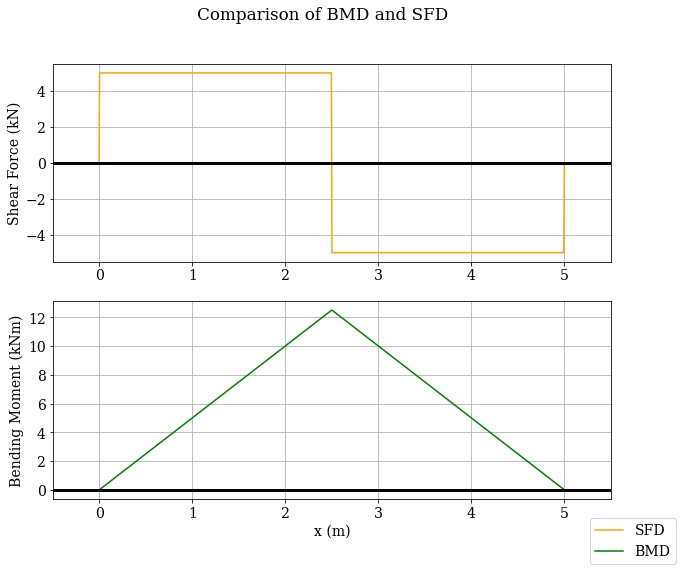

In [82]:
b = Beam(5)
p = PointLoad(b.length/2, 10, inverted=True)
ra = Reaction(0, 'h', 'A')
rb = Reaction(5, 'r', 'B')

b.add_loads((p, ra, rb))
b.add_moments((p, ra, rb))
b.calculate_reactions((ra,rb))
b.generate_moment_equation((p,ra,rb))
b.generate_shear_equation((p,ra,rb))

x = np.linspace(-1, b.length, 1000)
mom = b.mom_fn(x)
sf = b.shear_fn(x)

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10,8), edgecolor='w', facecolor='w')
axs[0].plot(x,sf,color='orange', label="SFD")
axs[0].set_ylabel("Shear Force (kN)")
axs[1].plot(x, mom,color='green', label='BMD')
axs[1].set_xlabel("x (m)")
axs[1].set_ylabel("Bending Moment (kNm)")
fig.suptitle("Comparison of BMD and SFD")
for ax in axs:
    ax.set_xticks(range(0, b.length+1,1))
    ax.set_xlim(-0.5, b.length+0.5)
    ax.axhline(y=0, linewidth=3, color='k')
    ax.grid()
fig.legend(loc='lower right')
plt.show()


0 0 0
R_B_x R_A_y + R_B_y - 10.0 50.0 - 10*R_A_y
[R_A_y, R_B_x, R_B_y]
[Eq(R_B_x, 0), Eq(R_A_y + R_B_y - 10.0, 0), Eq(50.0 - 10*R_A_y, 0), True]
{R_B_x: 0.0, R_A_y: 5.00000000000000, R_B_y: 5.00000000000000}
{R_B_x: 0.0, R_A_y: 5.00000000000000, R_B_y: 5.00000000000000}
5.00000000000000
5.00000000000000 0.0 5.00000000000000
5.0*SingularityFunction(x, 0, 0) - 10.0*SingularityFunction(x, 5.0, 0) + 5.0*SingularityFunction(x, 10, 0)


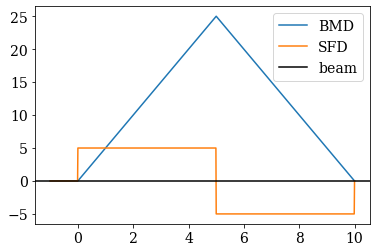

In [13]:
b = Beam(length=10)
p = PointLoad(b.length/2, 10, True)
ra = Reaction(0, 'r', 'A')
rb = Reaction(b.length, 'h', 'B')
print(ra.ry_val, rb.rx_val, rb.ry_val)
b.add_loads((p,ra,rb))
b.add_moments((p,ra,rb), about=b.length)
print(b.fx, b.fy, b.m)
b.calculate_reactions((ra,rb))
print(b.solved_rxns)
print(b.solved_rxns[rb.ry_var])
print(ra.ry_val, rb.rx_val, rb.ry_val)
b.generate_moment_equation(loads=[p,ra,rb])
b.generate_shear_equation(loads=[p,ra,rb])
x = np.linspace(-1, b.length, 1000)
fig, ax = plt.subplots()
ax.plot(x, b.mom_fn(x), label='BMD')
ax.plot(x,b.shear_fn(x), label="SFD")
ax.axhline(y=0, color='k', label='beam')
ax.legend()
plt.show()

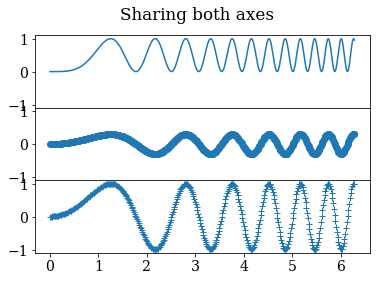

In [46]:
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)
fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
axs[0].plot(x, y ** 2)
axs[1].plot(x, 0.3 * y, 'o')
axs[2].plot(x, y, '+')

# Hide x labels and tick labels for all but bottom plot.
for ax in axs:
    ax.label_outer()